c:\Users\91966\Downloads\AI_model_2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 1 chunk file(s): ['AI_Training_Document_cleaned_chunks.jsonl']
Loaded 3 chunks and embeddings from embeddings_all-MiniLM-L6-v2.npy
FAISS index built with 3 vectors of dim 384

Query: Explain the purpose of the chatbot project.

[1] Score: 0.0511
It also contains an Agreement to Arbitrate which will, with limited  exception, require you to submit claims you have against us or related third parties to binding and  final arbitration, unless you opt out of the Agreement to Arbitrate in accordanc

[2] Score: -0.0052
Unless otherwise  expressly provided, eBay has no control over and does not guarantee: the existence, quality, safety,  or legality of items advertised; the truth or accuracy of users' content or listings; the ability of sellers

[3] Score: -0.0070
User Agreement  1. Introduction  This User Agreement, the Mobile Application Terms of Use, and all policies and additional terms  posted on and in our sites, applications, tools, and services (collectively "Services") set out th

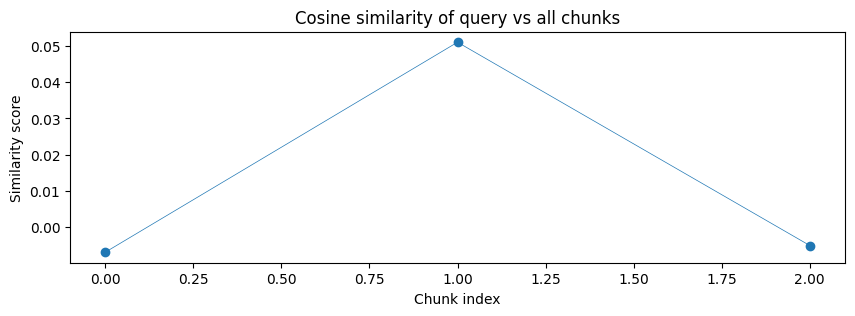


Saved top-5 retrieval results to ..\notebooks\output\retrieval_results.csv


In [1]:
from pathlib import Path
import json
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


# --- Configuration ---
OUTPUT_DIR = Path('../notebooks/output')
CHUNK_FILES = list(OUTPUT_DIR.glob('*_chunks.jsonl'))
print(f"Found {len(CHUNK_FILES)} chunk file(s):", [p.name for p in CHUNK_FILES])


EMBED_MODEL = 'all-MiniLM-L6-v2'
EMBED_FILE = OUTPUT_DIR / f"embeddings_{EMBED_MODEL.replace('/', '_')}.npy"


# --- Load chunks and embeddings ---
def load_chunks(path: Path):
    chunks = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            chunks.append(json.loads(line))
    return chunks

if CHUNK_FILES:
    sample_path = CHUNK_FILES[0]
    chunks = load_chunks(sample_path)
    texts = [c['text'] for c in chunks]
    embeddings = np.load(EMBED_FILE)
    print(f"Loaded {len(texts)} chunks and embeddings from {EMBED_FILE.name}")


# --- Normalize embeddings and build FAISS index ---
faiss.normalize_L2(embeddings)
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)
print(f"FAISS index built with {index.ntotal} vectors of dim {dim}")


# --- Query function ---
def search(query: str, top_k: int = 5):
    model = SentenceTransformer(EMBED_MODEL)
    q_emb = model.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    D, I = index.search(q_emb, top_k)
    results = []
    for score, idx in zip(D[0], I[0]):
        results.append({
        'score': float(score),
        'chunk_id': int(idx),
        'text': texts[idx]
        })
    return results


# --- Example search ---
query = "Explain the purpose of the chatbot project."
results = search(query, top_k=5)


print(f"\nQuery: {query}\n")
for i, r in enumerate(results, 1):
    print(f"[{i}] Score: {r['score']:.4f}\n{r['text'][:250].replace('\n',' ')}\n")


# --- Similarity heatmap (optional visualization) ---
import matplotlib.pyplot as plt


q_emb = SentenceTransformer(EMBED_MODEL).encode([query], convert_to_numpy=True)
faiss.normalize_L2(q_emb)
cos_sims = cosine_similarity(q_emb, embeddings)[0]


plt.figure(figsize=(10,3))
plt.plot(cos_sims, marker='o', linewidth=0.5)
plt.title('Cosine similarity of query vs all chunks')
plt.xlabel('Chunk index')
plt.ylabel('Similarity score')
plt.show()


# --- Save retrieval results ---
import pandas as pd


results_df = pd.DataFrame(results)
out_csv = OUTPUT_DIR / 'retrieval_results.csv'
results_df.to_csv(out_csv, index=False)
print(f"\nSaved top-{len(results)} retrieval results to {out_csv}")
